# Prototype Dataset
This file generates the path-to-path dataset to train a prototype transformer

The input output sequence of a logo should consist of 270 Parameters
- DeepSVG Embedding (256)
- a0 Type "EOS" (1)
- a1 - a6 Type (6)
- a7 - a12 Param (6)
- a13 time offset from beginning of animation in seconds

Input Sequence
- In the input sequence, the last 13 Parameters are set to zero
- In a final model, these parameters are aimed to be left out (as context vector isn't based on that)

Output Sequence
- The Output sequence consists of the selected paths represented by their DeepSVG Embedding
- The Animation is represented through the type and the parameters.
- Each output sequence ends with an EOS Token, where the EOS-type in the one-hot-encoded part is set to 1.

## Creating the input data

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests

file_path = 'data/test/embedded_data/svg_embedding.pkl'

# Open the pickle file for reading in binary mode
with open(file_path, 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)

print(data)

   animation_id         0         1         2         3         4         5  \
0             0 -1.479738  1.499942 -0.460764  0.363093 -0.947988 -1.115443   
1             1  0.813671  0.532380  1.347741  2.284749 -1.111322  0.691359   
2             3  0.604563 -1.073521  0.185603  0.023935 -0.398406  0.546429   
3             2  0.826920 -2.444922  0.851283 -0.252141  0.824601 -0.199929   
4             6  0.748827  0.006887  0.775695 -0.829792  0.439078  0.954797   
..          ...       ...       ...       ...       ...       ...       ...   
4             6 -0.187661  0.401433 -0.100404  0.636203 -0.474901  1.383271   
5             7  0.877559 -1.188825  1.372045 -0.126786 -0.186506 -0.021710   
6             5 -0.833903  0.496440  0.277829  0.364739 -1.040107  0.297266   
7             4 -0.400199  0.921548  0.191972  0.333160 -1.018423 -1.097480   
8             8  0.877559 -1.188825  1.372045 -0.126786 -0.186506 -0.021710   

           6         7         8  ...       247    

In [2]:
# checking the number of paths 

data['filename'].value_counts()
data["filename"]=data["filename"].str.replace(".svg","")

C:\Users\Okan\AppData\Local\Temp\ipykernel_20956\3690324963.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data["filename"]=data["filename"].str.replace(".svg","")


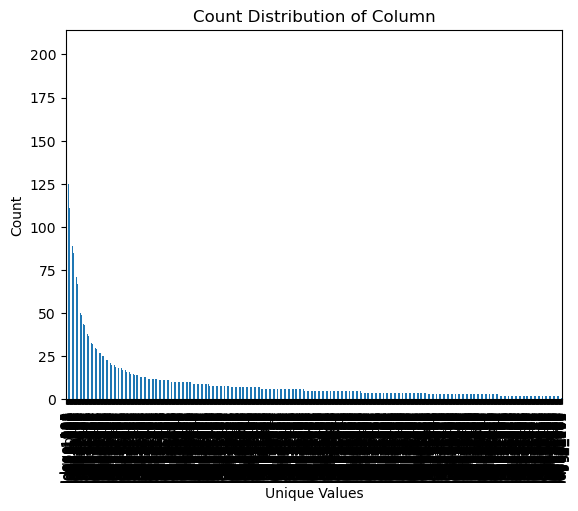

In [3]:
count_distribution = data['filename'].value_counts()
count_distribution.plot(kind='bar')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count Distribution of Column')
plt.show()

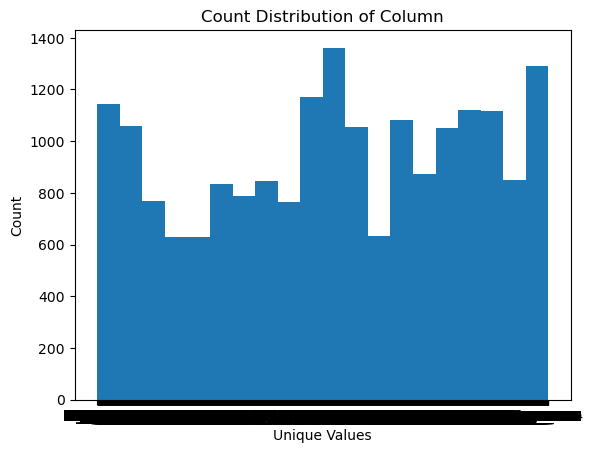

In [4]:
plt.hist(data['filename'], bins=20)  # You can adjust the number of bins as needed
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count Distribution of Column')
plt.show()

In [5]:
# max number of paths in one logo
data['filename'].value_counts().iloc[0]

204

In [6]:
data[data['filename']=='logo_36']

,animation_id,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,filename
0,0,-1.479738,1.499942,-0.460764,0.363093,-0.947988,-1.115443,1.581553,-0.411030,0.169418,...,1.718861,-0.139440,-1.523274,-1.602520,0.121773,-0.331636,1.083312,1.555735,0.406794,logo_36
1,1,-0.046564,1.268721,0.179297,0.520527,0.102936,0.511308,0.318602,0.652480,-0.204564,...,0.470238,-0.319376,0.230528,0.867940,0.395773,1.336052,0.325830,0.626101,-0.292177,logo_36
2,3,0.078027,-0.885305,0.575409,0.644550,0.071136,1.975846,-0.815557,-0.023037,-0.983261,...,-2.104513,0.376560,1.087818,1.251735,-0.982731,-0.423921,0.295719,-0.759669,-0.560176,logo_36
3,2,0.298474,-1.835696,0.278614,-0.592662,0.103240,0.527570,-0.301879,-0.378880,-0.419961,...,-3.453290,-0.456308,1.361012,0.638535,-0.515345,0.179005,0.714492,-0.504355,-0.210751,logo_36
4,4,0.043930,0.052075,-0.245103,0.936828,-0.281573,1.871222,-1.050934,0.586057,-0.180195,...,-0.875970,-0.431099,0.048782,1.273455,0.410215,-0.542904,0.352429,-1.753664,-0.421086,logo_36


In [7]:
type(data['animation_id'][118])

pandas.core.series.Series

In [8]:
# Read CSV into DataFrame
df = pd.read_csv('data/test/test_rating.csv')

df['id'] = df.index

# separating to rating and animation
animation_df = df[['id','filename','data', "rating"]]

rating_df = df[['id','filename','rating']]


In [9]:
animation_df

,id,filename,data,rating
0,0,logo_0.svg,"0,0,0,0,0,0,0,0,0,0,1,0,5,-42,21,9,-19,19.9634...",0
1,1,logo_10.svg,"1,0,1,0,0,0,0,0,0,0,0,0,5,-27,25,31,11,7.11032...",2
2,2,logo_100.svg,"0,0,0,0,0,0,0,0,0,1,0,0,5,-40,3,-35,-14,15.270...",1
3,3,logo_1000.svg,"2,0,0,0,1,0,0,0,0,0,0,0,2,-36,45,-5,4,14.75718...",3
4,4,logo_1002.svg,"2,0,0,1,0,0,0,0,0,0,0,0,5,6,44,12,22,19.073827...",4
...,...,...,...,...
1211,1211,logo_992.svg,"1,0,0,1,0,0,0,0,0,0,0,0,3,31,5,-10,20,8.561946...",3
1212,1212,logo_994.svg,"1,0,0,0,1,0,0,0,0,0,0,0,2,-9,25,-2,-37,19.5780...",3
1213,1213,logo_995.svg,"12,0,1,0,0,0,0,0,0,0,0,3,4,-33,17,28,20,17.957...",0
1214,1214,logo_997.svg,"1,0,0,0,0,0,0,0,0,0,1,0,3,15,-8,46,13,13.07436...",4


In [10]:
# changing the structure of rating data 

# Split the 'data' column and explode
animation_df['data'] = animation_df['data'].str.rstrip(';').str.split(';')
animation_df = animation_df.explode('data')

# Reset the index
animation_df.reset_index(drop=True, inplace=True)

# separating the animation ids and animation params
animation_df[['animation_id','a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']] = animation_df['data'].str.split(',', expand=True)

animation_df[['animation_id']] = animation_df[['animation_id']].astype(int)

animation_df[['a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']] = animation_df[['a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']].astype(float)

# Create a new column with concatenated values from each row
animation_df['model_output'] = animation_df[['a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']].apply(lambda row: list(row), axis=1)

animation_df.drop(columns=['data','a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25'], inplace=True)

animation_df.to_csv("data/animated_svgs_dataframes/firebase_animations.csv", sep=";")
animation_df["model_output"] = list(animation_df["model_output"])
animation_df["model_output"]

C:\Users\Okan\AppData\Local\Temp\ipykernel_20956\2636578949.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animation_df['data'] = animation_df['data'].str.rstrip(';').str.split(';')


0        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
4        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
                               ...                        
11596    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
11597    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
11598    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
11599    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
11600    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
Name: model_output, Length: 11601, dtype: object

## PROTOTYPE DATASET START

## Import DeepSVG Embedding

In [11]:
import pickle

import torch

with open("data/test/embedded_data/svg_embedding.pkl", "rb") as f:
    deepsvg_embedding = pickle.load(f)
deepsvg_embedding["filename"] = deepsvg_embedding["filename"].str.replace(".svg","")

C:\Users\Okan\AppData\Local\Temp\ipykernel_20956\1557396266.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  deepsvg_embedding["filename"] = deepsvg_embedding["filename"].str.replace(".svg","")


In [12]:
## duplicate for further use
embeddings = deepsvg_embedding.copy() #for output sequences
input_sequences = deepsvg_embedding

In [13]:
embeddings['animation_id'] = embeddings['animation_id'].astype(int)
embeddings.head()

,animation_id,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,filename
0,0,-1.479738,1.499942,-0.460764,0.363093,-0.947988,-1.115443,1.581553,-0.411030,0.169418,...,1.718861,-0.139440,-1.523274,-1.602520,0.121773,-0.331636,1.083312,1.555735,0.406794,logo_317
1,1,0.813671,0.532380,1.347741,2.284749,-1.111322,0.691359,-0.612887,0.271518,0.192076,...,-0.052597,-0.979659,-0.048005,0.299631,-0.175612,0.398075,-1.440031,0.144165,-0.121433,logo_317
2,3,0.604563,-1.073521,0.185603,0.023935,-0.398406,0.546429,-1.303117,-0.541940,0.560240,...,-1.528893,1.675922,-0.168111,0.416425,-0.561400,0.621158,-0.186476,-1.263664,-0.170587,logo_317
3,2,0.826920,-2.444922,0.851283,-0.252141,0.824601,-0.199929,-1.647408,-0.863231,0.394409,...,-1.526990,0.357616,-0.498427,-0.018137,-1.255023,-0.537419,0.795689,-0.949324,-0.196484,logo_317
4,6,0.748827,0.006887,0.775695,-0.829792,0.439078,0.954797,0.273108,1.341984,-0.491753,...,-3.404412,0.084775,2.741245,1.973660,0.194424,0.844904,-0.456959,1.405042,-0.836645,logo_317


## Train / Test Split

### Logo Dataset Analysis
Most logos have only a few paths
Some logos have over 100 paths to animate

In [14]:
# Might not execute
# input_sequences['filename'].value_counts().hist(bins=100)

### Stratify on Number of Paths in Logo

In [15]:
# Count occurrences
logos = input_sequences.groupby('filename').size().reset_index(name='count')

# To stratify later, categorize the sizes
bins = 20
quantiles = [(i+1)/bins for i in range(bins)]
print(quantiles)

percentiles = logos['count'].quantile(quantiles)
print(percentiles)

# Function to categorize based on quantiles
def categorize_count(count):
    for i, percentile in enumerate(percentiles):
        if count <= percentile:
            return f"Quantile {i}"
    return f"Quantile {len(quantiles)}"

# Apply the categorization function to create a new column
logos['count_category'] = logos['count'].apply(categorize_count)
logos['count_category'].value_counts()

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
0.05      2.0
0.10      2.0
0.15      3.0
0.20      3.0
0.25      3.0
0.30      4.0
0.35      4.0
0.40      4.0
0.45      5.0
0.50      5.0
0.55      6.0
0.60      6.0
0.65      7.0
0.70      8.0
0.75     10.0
0.80     11.0
0.85     13.2
0.90     19.0
0.95     33.4
1.00    204.0
Name: count, dtype: float64


Quantile 2     263
Quantile 5     246
Quantile 0     240
Quantile 8     216
Quantile 10    162
Quantile 14    149
Quantile 12    109
Quantile 17     95
Quantile 19     93
Quantile 18     90
Quantile 13     83
Quantile 16     63
Quantile 15     44
Name: count_category, dtype: int64

### Train / Test split

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and testing sets, stratifying on 'count_category'
logos_train, logos_test = train_test_split(logos, test_size=0.2, stratify=logos['count_category'], random_state=42)

The distributions of lenghts are now similar. Outliers with a long sequence are in both datasets

<Axes: >

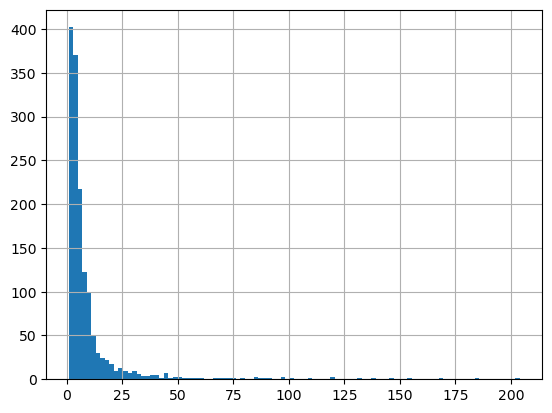

In [17]:
logos_train['count'].hist(bins=100)

<Axes: >

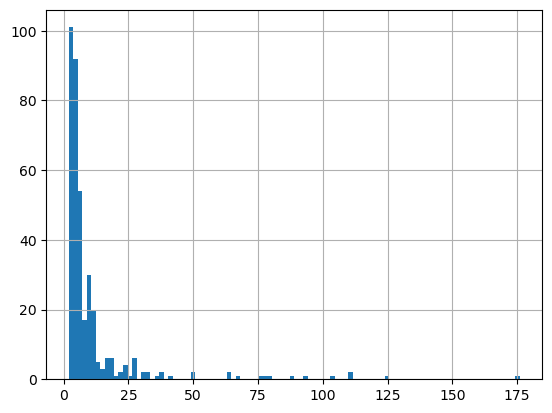

In [18]:
logos_test['count'].hist(bins=100)

In [19]:
logos_test = logos_test['filename'].unique()
logos_train = logos_train['filename'].unique()
logos_test

array(['logo_1535', 'logo_634', 'logo_1365', 'logo_1480', 'logo_830',
       'logo_1522', 'logo_66', 'logo_255', 'logo_124', 'logo_1122',
       'logo_1927', 'logo_955', 'logo_777', 'logo_1352', 'logo_758',
       'logo_531', 'logo_1214', 'logo_37', 'logo_575', 'logo_1704',
       'logo_836', 'logo_1917', 'logo_1381', 'logo_1007', 'logo_1925',
       'logo_1582', 'logo_1226', 'logo_334', 'logo_1263', 'logo_1611',
       'logo_1495', 'logo_637', 'logo_77', 'logo_1106', 'logo_968',
       'logo_603', 'logo_1245', 'logo_947', 'logo_1581', 'logo_1174',
       'logo_1822', 'logo_998', 'logo_1372', 'logo_1109', 'logo_1063',
       'logo_1801', 'logo_472', 'logo_1557', 'logo_631', 'logo_1224',
       'logo_1790', 'logo_663', 'logo_54', 'logo_1296', 'logo_417',
       'logo_1083', 'logo_1164', 'logo_1632', 'logo_1738', 'logo_646',
       'logo_1111', 'logo_1079', 'logo_1376', 'logo_200', 'logo_1624',
       'logo_8', 'logo_0', 'logo_850', 'logo_1380', 'logo_1040',
       'logo_976', 'logo_99',

### Discussion
- One might also stratify over used animation types.
- Are there enough good animations in the dataset for logos with lots of paths? -> Manual annotation

## Animation Dataset

In [20]:
import pickle
import pandas as pd

# Load the pickle file
with open("data/surrogate_model/animation_label.pkl", "rb") as f:
    imported_pickle = pickle.load(f)

# Create a DataFrame from the imported data
filtered_data = pd.DataFrame(imported_pickle, columns=["file", "animation_id", "model_output", "label"])

filtered_data = pd.read_csv("data/animated_svgs_dataframes/firebase_animations.csv", sep=";").rename(columns={"filename":"file", "rating" : "label"})

# Define the mapping for ratings
#mapping_dict = {"Very Good": 6, "Good": 5, "Okay": 4, "Bad": 3, "Very Bad": 2, "no_rating": 1}
# Replace the 'label' column with the corresponding ratings using .map
#filtered_data['rating'] = filtered_data['label'].map(mapping_dict)
filtered_data['rating'] = filtered_data['label']

# Extract unique logos by splitting 'file' with "_animation" and using .str.get(0)
#logos_unique = filtered_data['file'].str.split('_animation').str.get(0).unique()

In [21]:
#example
filtered_data[filtered_data["file"].str.contains("logo_5")]

,Unnamed: 0,id,file,label,animation_id,model_output,rating
8216,8216,888,logo_50.svg,1,2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
8217,8217,889,logo_500.svg,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",1
8218,8218,889,logo_500.svg,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1
8219,8219,889,logo_500.svg,1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1
8220,8220,890,logo_501.svg,0,0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...
9398,9398,955,logo_599.svg,1,13,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
9399,9399,955,logo_599.svg,1,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
9400,9400,955,logo_599.svg,1,19,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1
9401,9401,955,logo_599.svg,1,22,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


### Consistency: Delete twice animated paths in one animation
Every animation should animate each path only once. **But there are duplicates.**
Some duplicates are completely equal.

In [22]:
# Example
filtered_data[filtered_data['file'] == "logo_379_animation_5"]
filtered_data.head()

,Unnamed: 0,id,file,label,animation_id,model_output,rating
0,0,0,logo_0.svg,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,1,0,logo_0.svg,0,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,2,1,logo_10.svg,2,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
3,3,2,logo_100.svg,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1
4,4,2,logo_100.svg,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",1


In [23]:
# SIMPLE DUPLICATE REDUCTION
print(f"There are {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

# Create a copy for and convert numpy to strings
duplicate_search = filtered_data.copy()
duplicate_search['model_output'] = duplicate_search['model_output'].apply(lambda x: str(x))

# Find duplicates in the copy and remove with a mask
duplicates_mask = duplicate_search.duplicated(keep='first')
filtered_data = filtered_data[~duplicates_mask]

print(f"Reduced to {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

There are 5457 duplicates.
Reduced to 5457 duplicates.


But there are some more duplicates. Some have different ratings, so let's simply keep the better rating:

In [24]:
duplicates_mask = filtered_data.duplicated(subset=['file', 'animation_id'], keep=False)
filtered_data[duplicates_mask]

,Unnamed: 0,id,file,label,animation_id,model_output,rating
0,0,0,logo_0.svg,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,1,0,logo_0.svg,0,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
6,6,3,logo_1000.svg,3,2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
8,8,3,logo_1000.svg,3,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",3
10,10,4,logo_1002.svg,4,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
...,...,...,...,...,...,...,...
11582,11582,1210,logo_991.svg,1,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1
11584,11584,1210,logo_991.svg,1,9,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
11585,11585,1210,logo_991.svg,1,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
11592,11592,1213,logo_995.svg,0,8,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [25]:
# Sort the DataFrame by 'file', 'animation_id' (for grouping) and 'rating' (descending order to prioritize higher ratings)
filtered_data_sorted = filtered_data.sort_values(by=['file', 'animation_id', 'rating'], ascending=[True, True, False])

# Mark duplicates, keeping the row with the highest rating
duplicates_mask = filtered_data_sorted.duplicated(subset=['file', 'animation_id'], keep='first')

# Identify the indices of rows to keep and filter the original DataFrame
indices_to_keep = filtered_data_sorted[~duplicates_mask].index

filtered_data = filtered_data.loc[filtered_data.index.intersection(indices_to_keep)]

print(f"Reduced to {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

Reduced to 0 duplicates.


Now all duplicates are gone. Let's check with an example:

In [26]:
# Check: Should be 7 animations instead of 14 
filtered_data[filtered_data['file'] == "logo_379.svg"]  # EG: logo_379_animation_5 , logo_334_animation_12

,Unnamed: 0,id,file,label,animation_id,model_output,rating


In [27]:
filtered_data.reset_index(drop=True, inplace=True)

### Some Statistics about the Animations we have here
Result: Many animations with only one animated path

In [28]:
grouped = filtered_data.groupby('file').count()
grouped = grouped[['animation_id']]
print(f"{grouped.size} Animations initially")
histogram_table = grouped['animation_id'].value_counts().reset_index()
histogram_table.columns = ['Animation Length', 'Count']
histogram_table = histogram_table.sort_values(by='Animation Length')
print(histogram_table)

1216 Animations initially
    Animation Length  Count
0                  1    387
1                  2    290
2                  3    176
3                  4    115
4                  5     56
5                  6     37
6                  7     28
7                  8     14
8                  9     14
9                 10     10
11                11      7
10                12      9
12                13      7
15                14      4
16                15      3
14                16      4
13                17      5
18                18      3
23                19      2
49                20      1
17                21      3
21                24      2
43                26      1
52                28      1
24                29      2
26                30      1
44                32      1
28                35      1
50                36      1
45                38      1
29                39      1
54                40      1
38                41      1
34                42  

In [29]:
grouped = filtered_data.groupby('label').count()
grouped = grouped[['file']].reset_index()
grouped.columns = ['Rating', 'Count']
grouped['Percentage'] = (grouped['Count'] / grouped['Count'].sum()) * 100
grouped

,Rating,Count,Percentage
0,0,4013,46.875365
1,1,3041,35.521551
2,2,689,8.048125
3,3,708,8.270062
4,4,110,1.284897


### Investigate overall rating of animations

<Axes: >

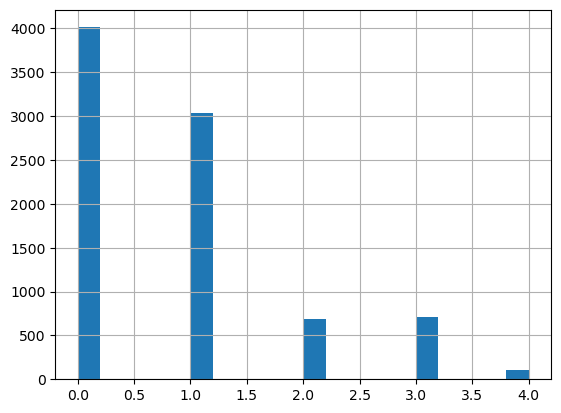

In [30]:
filtered_data['average_rating'] = filtered_data.groupby('file')['rating'].transform('mean')
filtered_data['average_rating'].hist(bins=20)

In [31]:
# example
filtered_data[filtered_data["file"].str.contains("logo_5_")]

,Unnamed: 0,id,file,label,animation_id,model_output,rating,average_rating


### Now pick good Animations only
Pick the following animations
- Best per logo (include as many different logos as possible)
- Add all GOOD animations (additionally add as many animations as possible) TODO: Implement later

In [32]:
filtered_data['include'] = 0

In [33]:
# use all animations with an average rating over 3
minimum_rating = 3
temp = filtered_data['average_rating'] > minimum_rating
filtered_data.loc[temp, 'include'] = 1

In [34]:
print(f"{filtered_data['include'].mean() * 100}% of the data is left out")

1.2848966242261417% of the data is left out


In [35]:
# go through each logo to find the best animation
for logo in logos:
    # make a data frame that contains all the animations of one logo
    temp = filtered_data[filtered_data["file"].str.contains(logo)]

    best_logo = temp[temp['average_rating'] == temp['average_rating'].max()]
    best_logo = best_logo['file'].unique()
    
    filtered_data.loc[filtered_data['file'].isin(best_logo), 'include'] = 1
    break

In [36]:
print(f"Now {filtered_data['include'].mean() * 100}% of the data is left out")

Now 1.2848966242261417% of the data is left out


Note: No additional animations are selected

In [37]:
best_output = filtered_data[filtered_data['include'] == 1].copy()
best_output.drop(columns=['include'], inplace=True, axis=1)

In [38]:
# extract logo
pattern = r'(logo_\d+)'
best_output['filename'] = best_output['file'].str.extract(pattern)

### Numeration to keep order later (corresponds to start-time)

In [39]:
# Create a time_offset column filled with zeros
best_output['a13'] = 0.0

# Define animation start time offset in seconds from animation start
TIME_OFFSET_STEP = 0.25

# Initialize a dictionary to store numbering for each file
file_counts = {}

# Iterate through the "file" column and number each unique file
for index, row in best_output.iterrows():
    filename = row['file']
    if filename not in file_counts:
        file_counts[filename] = 1
    else:
        file_counts[filename] += 1
    best_output.at[index, 'a13'] = file_counts[filename] * TIME_OFFSET_STEP
best_output.head()

,Unnamed: 0,id,file,label,animation_id,model_output,rating,average_rating,filename,a13
8,10,4,logo_1002.svg,4,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,4.0,logo_1002,0.25
9,11,4,logo_1002.svg,4,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",4,4.0,logo_1002,0.50
10,13,4,logo_1002.svg,4,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,4.0,logo_1002,0.75
72,97,26,logo_1035.svg,4,1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,4.0,logo_1035,0.25
168,217,67,logo_1094.svg,4,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",4,4.0,logo_1094,0.25


### Stat: Animated paths per logo

In [40]:
used_paths = best_output[["filename", "animation_id"]].drop_duplicates(
    subset = ['filename', 'animation_id'], keep = 'last').reset_index(drop = True)
used_paths.head()

,filename,animation_id
0,logo_1002,2
1,logo_1002,1
2,logo_1002,0
3,logo_1035,1
4,logo_1094,3


array([[<Axes: title={'center': 'animation_id'}>]], dtype=object)

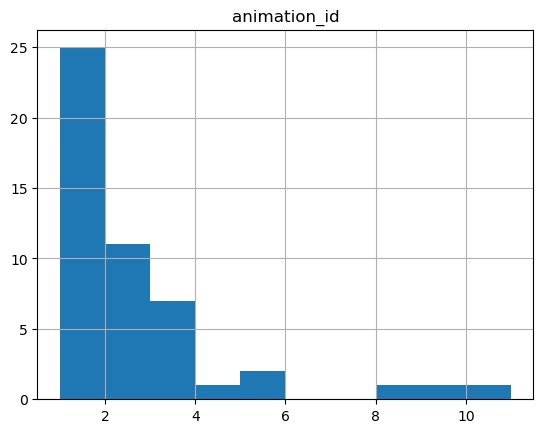

In [41]:
used_paths.groupby(['filename']).count().hist()

### Some Statistics again


In [42]:
grouped = best_output.groupby('file').count()
grouped = grouped[['animation_id']]
print(f"{grouped.size} Animations left over")
histogram_table = grouped['animation_id'].value_counts().reset_index()
histogram_table.columns = ['Animation Length', 'Count']
histogram_table = histogram_table.sort_values(by='Animation Length')
print(histogram_table)

49 Animations left over
   Animation Length  Count
0                 1     25
1                 2     11
2                 3      7
4                 4      1
3                 5      2
6                 8      1
7                 9      1
5                11      1


# Build sequences

## Make List of all Data Samples

### Apply Stats

In [43]:
final_animation_stats = best_output[['filename', 'file', 'model_output']].copy()
final_animation_stats['animation_length'] = 1
for i in range(10):
 final_animation_stats[f'a{i+1}'] = final_animation_stats['model_output'].apply(lambda x: float(x.split(",")[i].replace("[","").replace("]","")))
final_animation_stats.drop(['model_output'], inplace=True, axis=1)
final_animation_stats

,filename,file,animation_length,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10
8,logo_1002,logo_1002.svg,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,logo_1002,logo_1002.svg,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10,logo_1002,logo_1002.svg,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,logo_1035,logo_1035.svg,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
168,logo_1094,logo_1094.svg,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8488,logo_962,logo_962.svg,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8505,logo_972,logo_972.svg,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8506,logo_972,logo_972.svg,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8507,logo_972,logo_972.svg,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Group by logo & animation

In [44]:
final_animations_index = final_animation_stats.groupby(['filename', 'file']).sum()
final_animations_index['a0'] = 1 # EOS one per animation sequence
final_animations_index = final_animations_index.reset_index()
final_animations_index

,filename,file,animation_length,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a0
0,logo_1002,logo_1002.svg,3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,logo_1035,logo_1035.svg,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,logo_1094,logo_1094.svg,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,logo_1123,logo_1123.svg,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,logo_1145,logo_1145.svg,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
5,logo_1159,logo_1159.svg,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,logo_1184,logo_1184.svg,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,logo_1198,logo_1198.svg,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
8,logo_1230,logo_1230.svg,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
9,logo_1237,logo_1237.svg,4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1


### Balance and Oversampling

In [45]:
final_animations_index['repeat'] = 1

def print_balancing_stats(df: pd.DataFrame, silent=False):
    temp = df.copy()
    temp = temp[~temp['filename'].isin(logos_test)] # train data only
    temp = temp.reset_index().drop(['filename', 'file','animation_length'], axis=1)
    for i in range(0, 7):
        temp[f'a{i}'] = temp[f'a{i}'] * temp['repeat']
    balance = temp[['a1', 'a2', 'a3', 'a4', 'a5', 'a6']].sum()
    balance_percentage = min(balance) / max(balance)
    balance_diff = max(balance) - min(balance)
    if silent:
        return balance_diff, balance_percentage, balance.nsmallest(6).index
    print(f"Balanced with oversampling {int(temp['repeat'].sum() / len(temp) * 100)-100}% to {int(balance_percentage * 100)}%")
    print(balance)
    
print_balancing_stats(final_animations_index)

Balanced with oversampling 0% to 0%
a1     0.0
a2     7.0
a3     9.0
a4    12.0
a5    11.0
a6     8.0
dtype: float64


In [46]:
print_balancing_stats(final_animations_index, silent=True)

(12.0, 0.0, Index(['a1', 'a2', 'a6', 'a3', 'a5', 'a4'], dtype='object'))

Currently, EOS (a0) occurs much more often then the other animation types.

Let's oversample all sequences > 1

In [47]:
final_animations_index[final_animations_index['filename'] == 'logo_2']

,filename,file,animation_length,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a0,repeat


Through oversampling, this can be optimized...

In [48]:
# Very fancy sampling
def get_filter_mask(df, rare_animations, second_rarest=False, second_most_frequent=False, max_repetition=8):
    if second_rarest and second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      (df[rare_animations[1]] > 0) &
                      (df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    if second_rarest and not second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      #(df[rare_animations[1]] > 0) &
                      (df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    if not second_rarest and second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      (df[rare_animations[1]] > 0) &
                      #(df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    return df.loc[(df[rare_animations[0]] > 0) & 
                  #(df[rare_animations[1]] > 0) &
                  #(df[rare_animations[4]] == 0) &
                  (df[rare_animations[5]] == 0) &
                  (df['repeat'] < df['animation_length'] + 2) &
                  (df['repeat'] < max_repetition)]

final_animations_index['repeat'] = 1
sample_size = 5

for i in range(1000):
    balance_diff, balance, rare_animations = print_balancing_stats(final_animations_index, silent=True)
    if balance_diff < 20:
        sample_size = 1
        filtering = get_filter_mask(final_animations_index, rare_animations, second_most_frequent=True, max_repetition=8)

    else:
        filtering = get_filter_mask(final_animations_index, rare_animations, second_rarest=True, second_most_frequent=True, max_repetition=6)
        if len(filtering == 0):
            filtering = get_filter_mask(final_animations_index, rare_animations, second_most_frequent=True, max_repetition=7)
            if len(filtering == 0):
                filtering = get_filter_mask(final_animations_index, rare_animations, max_repetition=8)
            
    if balance_diff < 20:
        print(f"Final oversampling: {balance_diff} difference, {len(filtering)} in filtering")
    if balance_diff < 2:
        print(f"Break after {i} Iterations")
        break

    random_indices = filtering.sample(n=min(sample_size, len(filtering))).index.tolist()
    final_animations_index.loc[random_indices, 'repeat'] += 1
    
print_balancing_stats(final_animations_index)

Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversampling: 12.0 difference, 0 in filtering
Final oversa

<Axes: >

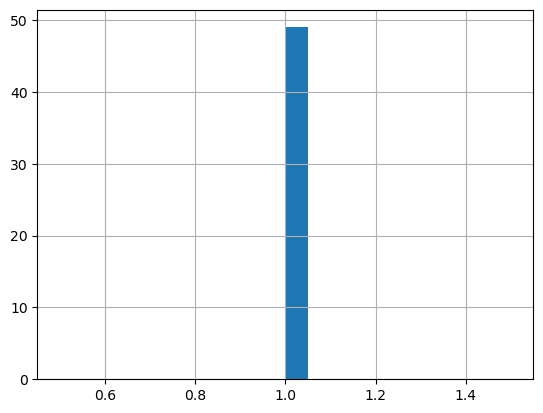

In [49]:
final_animations_index['repeat'].hist(bins=20)

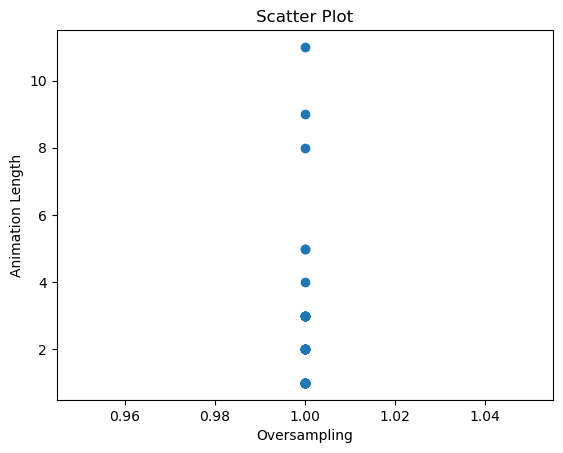

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the two columns for the scatter plot
x = final_animations_index['repeat']
y = final_animations_index['animation_length']

# Create a scatter plot
plt.scatter(x, y)

# Add labels and a title
plt.xlabel('Oversampling')
plt.ylabel('Animation Length')
plt.title('Scatter Plot')

# Show the plot
plt.show()

In [51]:
final_animations_index[final_animations_index['filename'] == 'logo_2']

,filename,file,animation_length,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a0,repeat


### Merge logo stats

In [52]:
logos.head()

,filename,count,count_category
0,logo_0,3,Quantile 2
1,logo_1,5,Quantile 8
2,logo_10,7,Quantile 12
3,logo_100,3,Quantile 2
4,logo_1000,4,Quantile 5


In [53]:
final_animations_index = final_animations_index.merge(logos[["filename","count"]], on='filename', how='left')
final_animations_index.rename(columns={'count': 'num_paths'}, inplace=True)
final_animations_index["file"] = final_animations_index["file"].str.replace(".svg","")
final_animations_index

C:\Users\Okan\AppData\Local\Temp\ipykernel_20956\1313802563.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  final_animations_index["file"] = final_animations_index["file"].str.replace(".svg","")


,filename,file,animation_length,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a0,repeat,num_paths
0,logo_1002,logo_1002,3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,4.0
1,logo_1035,logo_1035,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2.0
2,logo_1094,logo_1094,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,5.0
3,logo_1123,logo_1123,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,3.0
4,logo_1145,logo_1145,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,3.0
5,logo_1159,logo_1159,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,NaN
6,logo_1184,logo_1184,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2.0
7,logo_1198,logo_1198,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1,1,9.0
8,logo_1230,logo_1230,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,NaN
9,logo_1237,logo_1237,4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1,1,6.0


### Plot: Number of Paths vs Animation Length

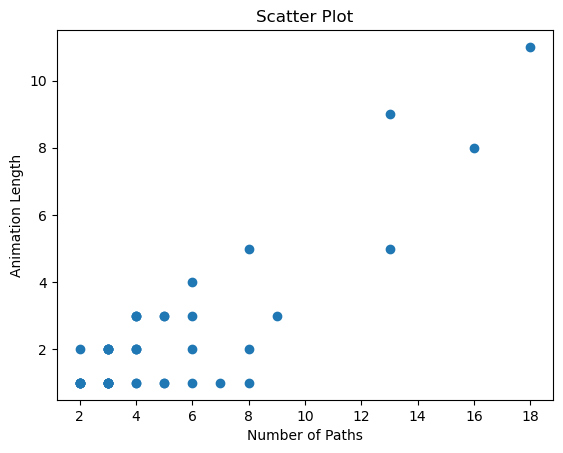

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the two columns for the scatter plot
x = final_animations_index['num_paths']
y = final_animations_index['animation_length']

# Create a scatter plot
plt.scatter(x, y)

# Add labels and a title
plt.xlabel('Number of Paths')
plt.ylabel('Animation Length')
plt.title('Scatter Plot')

# Show the plot
plt.show()

## Bucketing
For batching the data later on, build buckets to group animations with similar length characteristics

In [55]:
# from dataset_helper import generate_buckets_2D
# generate_buckets_2D(final_animations_index,
#                  'count',
#                  'animation_length',
#                  [0.2, 0.4, 0.6, 0.8, 1],
#                  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Build Input Sequences Dictionary

In [56]:
def build_input_sequences_dict(sequences: pd.DataFrame, used_paths: pd.DataFrame, is_used_path_filtering = False, keep_unused=False):
    initial_length = len(sequences)
    used_paths['animation_id'] = used_paths['animation_id'].astype(str)
    if is_used_path_filtering:
        if keep_unused:
            # If keeping unused paths, perform a left merge and then filter where used paths are NaN
            sequences = pd.merge(sequences, used_paths, on=['filename', 'animation_id'], how='left', indicator=True)
            sequences = sequences[sequences['_merge'] == 'left_only'].drop(columns=['_merge']).copy()
            print(sequences)
            print(f"Filtering of input sequences to keep only unused paths. Reduction from {initial_length} to {len(sequences)} paths.")
        else:
            # If not keeping unused paths, perform an inner merge to keep only used paths
            sequences = pd.merge(sequences, used_paths, on=['filename', 'animation_id']).copy()
            #print(sequences, used_paths)
            print(f"Filtering of input sequences on only used paths. Reduction from {initial_length} to {len(sequences)} paths.")
    
    dict = {}
    for logo in sequences["filename"].unique():
        dict[logo] = sequences[sequences["filename"]==logo]
    #print(dict)
    return dict

In [57]:
input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")
input_sequences_dict_used = build_input_sequences_dict(input_sequences, used_paths, is_used_path_filtering=True)
print(input_sequences_dict_used.keys())
#input_sequences_dict_used[logos_train[0]]

Filtering of input sequences on only used paths. Reduction from 19061 to 105 paths.
dict_keys(['logo_707', 'logo_1198', 'logo_31', 'logo_1002', 'logo_258', 'logo_1388', 'logo_1411', 'logo_22', 'logo_267', 'logo_1955', 'logo_997', 'logo_1303', 'logo_417', 'logo_55', 'logo_1260', 'logo_1739', 'logo_1922', 'logo_962', 'logo_630', 'logo_72', 'logo_395', 'logo_1723', 'logo_1450', 'logo_637', 'logo_1243', 'logo_1479', 'logo_1447', 'logo_1123', 'logo_1094', 'logo_1240', 'logo_972', 'logo_1145', 'logo_1554', 'logo_257', 'logo_914', 'logo_679', 'logo_1609', 'logo_1184', 'logo_28', 'logo_1552', 'logo_1432', 'logo_455', 'logo_1237', 'logo_1035'])


C:\Users\Okan\AppData\Local\Temp\ipykernel_20956\4019560022.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")


In [58]:
input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")
input_sequences_dict_unused = build_input_sequences_dict(input_sequences, used_paths, is_used_path_filtering=True, keep_unused=True)
#input_sequences_dict_unused[logos_train[0]]

C:\Users\Okan\AppData\Local\Temp\ipykernel_20956\1504954084.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")


      animation_id         0         1         2         3         4  \
0                0 -1.479738  1.499942 -0.460764  0.363093 -0.947988   
1                1  0.813671  0.532380  1.347741  2.284749 -1.111322   
2                3  0.604563 -1.073521  0.185603  0.023935 -0.398406   
3                2  0.826920 -2.444922  0.851283 -0.252141  0.824601   
4                6  0.748827  0.006887  0.775695 -0.829792  0.439078   
...            ...       ...       ...       ...       ...       ...   
19056            6 -0.187661  0.401433 -0.100404  0.636203 -0.474901   
19057            7  0.877559 -1.188825  1.372045 -0.126786 -0.186506   
19058            5 -0.833903  0.496440  0.277829  0.364739 -1.040107   
19059            4 -0.400199  0.921548  0.191972  0.333160 -1.018423   
19060            8  0.877559 -1.188825  1.372045 -0.126786 -0.186506   

              5         6         7         8  ...       247       248  \
0     -1.115443  1.581553 -0.411030  0.169418  ...  1.718861 

## Build Output Sequence (Embedded Paths with Animation Vector)

In [59]:
# Merge Dataframes
output_sequence = pd.merge(best_output, embeddings, on=['filename', 'animation_id'], how='inner')
animation_vectors=pd.DataFrame()
for i in range(26):
 animation_vectors[f'a{i+1}'] = output_sequence['model_output'].apply(lambda x: float(x.split(",")[i].replace("[","").replace("]","")))
#animation_vectors = pd.DataFrame(output_sequence["model_output"].to_list(), columns=["a1","a2","a3","a4","a5","a6","a7","a8","a9","a10","a11","a12"])
output_sequence.drop(['animation_id', 'model_output', 'label', 'rating', 'average_rating'], inplace=True, axis=1)
output_sequence['a0'] = 0 # EOS Feature in One-hot Encoding
output_sequence = pd.merge(output_sequence, animation_vectors, left_index=True, right_index=True)
output_sequence["file"] = output_sequence["file"].str.replace(".svg","")

C:\Users\Okan\AppData\Local\Temp\ipykernel_20956\2192890791.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  output_sequence["file"] = output_sequence["file"].str.replace(".svg","")


In [60]:
# Move column 'a13' to the back
column_to_move = 'a10'
new_order = [col for col in output_sequence.columns if col != column_to_move]
new_order.append(column_to_move)
output_sequence = output_sequence[new_order]

In [61]:
output_sequence.head()

,Unnamed: 0,id,file,filename,a13_x,0,1,2,3,4,...,a18,a19,a20,a21,a22,a23,a24,a25,a26,a10
0,10,4,logo_1002,logo_1002,0.25,0.395026,-2.363052,1.162360,-1.869007,1.078318,...,183.0,3.0,-10.0,96.0,55.0,89.0,84.141881,39.0,0.0,0.0
1,11,4,logo_1002,logo_1002,0.50,-0.771108,0.521610,-0.412989,1.144691,-0.795480,...,163.0,-41.0,-7.0,143.0,103.0,169.0,39.452749,48.0,0.0,0.0
2,13,4,logo_1002,logo_1002,0.75,-0.416353,0.517834,-0.332476,1.118919,-0.616921,...,296.0,23.0,-30.0,88.0,43.0,91.0,12.642554,22.0,0.0,0.0
3,97,26,logo_1035,logo_1035,0.25,0.903929,0.345673,0.188079,0.015912,-0.459795,...,116.0,-14.0,23.0,88.0,200.0,59.0,49.396612,50.0,0.0,0.0
4,217,67,logo_1094,logo_1094,0.25,-0.777652,0.390278,0.093014,2.161441,-0.577191,...,149.0,38.0,12.0,74.0,10.0,162.0,23.870837,80.0,0.0,0.0


## Main Iteration over all samples

In [62]:
from dataset_helper import generate_dataset


dataset = generate_dataset(final_animations_index,
                           input_sequences_dict_used,
                           input_sequences_dict_unused,
                           output_sequence,
                           {"train": logos_train, "test": logos_test},
                           sequence_length_input=8, # low as filtered
                           sequence_length_output=10, # input + SOS / EOS
                           )
# Executed in 1 minute with shortened padding ~Cornelius

Processing logo_1002 with logo_1002: 
Processing logo_1035 with logo_1035: 
Processing logo_1094 with logo_1094: 
Processing logo_1123 with logo_1123: 
Processing logo_1145 with logo_1145: 
Processing logo_1159 with logo_1159: 
Processing logo_1184 with logo_1184: 
Processing logo_1198 with logo_1198: 
Processing logo_1230 with logo_1230: 
Processing logo_1237 with logo_1237: 
Processing logo_1240 with logo_1240: 
Processing logo_1243 with logo_1243: 
Processing logo_1260 with logo_1260: 
Processing logo_1303 with logo_1303: 
Processing logo_1388 with logo_1388: 
Processing logo_1411 with logo_1411: 
Processing logo_1432 with logo_1432: 
Processing logo_1447 with logo_1447: 
Processing logo_1450 with logo_1450: 
Processing logo_1479 with logo_1479: 
Processing logo_1552 with logo_1552: 
Processing logo_1554 with logo_1554: 
Processing logo_1609 with logo_1609: 
Processing logo_1723 with logo_1723: 
Processing logo_1739 with logo_1739: 
Processing logo_1922 with logo_1922: 
Processing l

## Result

In [63]:
torch.save(dataset["train"]["input"], 'data/prototype_dataset/train_sequence_input.pt')
torch.save(dataset["train"]["output"], 'data/prototype_dataset/train_sequence_output.pt')
torch.save(dataset["test"]["input"], 'data/prototype_dataset/test_sequence_input.pt')
torch.save(dataset["test"]["output"], 'data/prototype_dataset/test_sequence_output.pt')

In [64]:
print(dataset["train"]["input"].size())
print(dataset["train"]["output"].size())
print(dataset["test"]["input"].size())
print(dataset["test"]["output"].size())

torch.Size([33, 8, 270])
torch.Size([33, 10, 286])
torch.Size([10, 8, 270])
torch.Size([10, 10, 286])
